In [1]:
import sys
sys.path.append("../..")
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
# from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score
# import statsmodels.api as sm
# from scipy.stats import boxcox, pearsonr
import statsmodels.formula.api as smf
# import statsmodels.stats.multitest as multi
# from joblib import Parallel, delayed, parallel_backend
# from statsmodels.sandbox.tools import cross_val
# import gc
import scipy.io as sio

# from modeldb.sklearn_native import CrossValidationScore
# from sklearn.model_selection import GridSearchCV
# import traceback
import math

import networkx

from sklearn.model_selection import cross_val_score
from coh_tools import *
%matplotlib inline

# style.use("seaborn-colorblind")
style.use("tableau-colorblind10")

In [2]:
# Get experiment info
os.chdir("/home/julien/school/lab/opto_data_analysis/csvs")
# os.chdir(r"C:\Users\julienb\lab\oe_data_analysis\csvs")
experiments = pd.read_csv('table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]


In [3]:
multiband_allcon_dict = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/multiband_timefreq_allcon_dict.pkl", "rb"))
multiband_allcon_phase_dict = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/multiband_timefreq_allcon_phase_dict.pkl", "rb"))

# multiband_allcon_dict = pkl.load(open(r"C:\Users\julienb\lab\data\pickled\multiband_timefreq_allcon_dict.pkl", "rb"))
# multiband_allcon_phase_dict = pkl.load(open(r"C:\Users\julienb\lab\data\pickled\multiband_timefreq_allcon_phase_dict.pkl", "rb"))


In [14]:
block_keys = list(multiband_allcon_dict["theta"].keys())

In [16]:
for band in ["theta", "beta", "gamma", "high_gamma"]:
    data = multiband_allcon_dict[band]
    for bk in block_keys:
        data[block_keys]
    print(data[block_keys[0]].shape)

(1, 67, 67)
(1, 67, 67)
(1, 67, 67)
(1, 67, 67)


In [18]:
good_channels = pkl.load(open("/home/julien/school/lab/opto_data_analysis/pickled/good_channels.pkl", "rb"))


In [48]:
## Generate dataframe
## Do Stats ##
dataframes = {}
for band in ["theta", "beta", "gamma", "high_gamma"]:
# for band in ["theta"]:

    print(band)

    data_dict = multiband_allcon_dict[band]

    phasemeans = []
    condmeans = []
    basemeans = []
    newbasemeans = []
    delays = []
    deltacohs = []
    distances = []
    num_lasers = []
    coherence_projections = []
    block_nums = []
    experiment_block_keys = []
    pc1a = []
    pc2a = []
    pc1b = []
    pc2b = []
    monkeys = []
    both_m1 = []
    both_s1 = []
    
    ## GRAPH STUFF ##
    avg_weight = []
    max_eig = []
    sec_eig = []
    eig_gap = []
    min_eig = []
    coh_proj_avg = []
    
    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
        if (exp_num_laser == 0 or (row["stim_Coh_from"] == 0 and row["stim_Coh_to"] == 0)):
#             print(key)
            continue

        exp_good_channels = good_channels[key[:-3]]

        a_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_from"])
        b_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_to"])

        for block_num in np.arange(6)+1:                                        
            rec_key = key+"_RecBlock"+str(block_num)
            stim_key = key+"_CondBlock"+str(block_num)
            if block_num < 6:
                block_base_data = data_dict[rec_key].mean(0)
                basemeans.append(block_base_data.flatten())
                condmeans.append(data_dict[stim_key].mean(0).flatten())
                coherence_projections.append(np.dot(block_base_data, block_base_data).flatten())

                if block_num == 1:
                    scaler = StandardScaler()
                    scaled_base = scaler.fit_transform(np.vstack(data_dict[rec_key]))
                    pca = PCA(n_components=2)
                    pca.fit(scaled_base)
                ## Need to fix this PCA stuff so I have one for each electrode
                pca_data = pca.transform(scaler.transform(block_base_data))
                pc1a.append(np.repeat(pca_data[:, 0], pca_data.shape[0]))
                pc2a.append(np.repeat(pca_data[:, 1], pca_data.shape[0]))
                pc1b.append(np.tile(pca_data[:, 0], pca_data.shape[0]))
                pc2b.append(np.tile(pca_data[:, 1], pca_data.shape[0]))
                
                ## GRAPH STUFF HERE ##
                avg_weight.append(block_base_data.mean()*np.ones(block_base_data.size))
                eigs = np.linalg.eig(block_base_data)[0]
                max_eig.append(eigs[0]*np.ones(block_base_data.size))
                sec_eig.append(eigs[1]*np.ones(block_base_data.size))
                eig_gap.append((eigs[0]-eigs[1])*np.ones(block_base_data.size))
                min_eig.append(eigs[-1]*np.ones(block_base_data.size))
                coh_proj_avg.append(np.dot(block_base_data, block_base_data).mean()*np.ones(block_base_data.size)) 
                #some mofit
                
            if block_num > 1:
                newbasemeans.append(data_dict[rec_key].mean(0).flatten())

    basemeans = np.asarray(np.concatenate(basemeans)).flatten()
    newbasemeans = np.asarray(np.concatenate(newbasemeans)).flatten()
    condmeans = np.asarray(np.concatenate(condmeans)).flatten()
    coherence_projections = np.asarray(np.concatenate(coherence_projections)).flatten()
    pc1a = np.asarray(np.concatenate(pc1a)).flatten()
    pc2a = np.asarray(np.concatenate(pc2a)).flatten()
    pc1b = np.asarray(np.concatenate(pc1b)).flatten()
    pc2b = np.asarray(np.concatenate(pc2b)).flatten()
    
    avg_weight = np.asarray(np.concatenate(avg_weight)).flatten()
    max_eig = np.asarray(np.concatenate(max_eig)).flatten()
    sec_eig = np.asarray(np.concatenate(sec_eig)).flatten()
    eig_gap = np.asarray(np.concatenate(eig_gap)).flatten()
    min_eig = np.asarray(np.concatenate(min_eig)).flatten()
    coh_proj_avg = np.asarray(np.concatenate(coh_proj_avg)).flatten()
    
    cond_diff_Y = condmeans - basemeans
    cond_diff_percent_Y = (condmeans - basemeans)/basemeans
    diff_Y = newbasemeans - basemeans
    diff_percent_Y = (newbasemeans - basemeans)/basemeans

    data = pd.DataFrame({"Initial_coh": basemeans,
                        "Coh_proj": coherence_projections,
                        "PC1a": pc1a, "PC2a": pc2a, "PC1b": pc1b, "PC2b": pc2b,
                        "Avg_weight": avg_weight, "Max_eig": max_eig, "Sec_eig": sec_eig,
                        "Eig_gap": eig_gap, "Min_eig": min_eig, "Coh_proj_avg": coh_proj_avg})

    data["cond_diff_Y"] = cond_diff_Y  
    data["cond_diff_percent_Y"] = cond_diff_percent_Y
    data["diff_Y"] = diff_Y
    data["diff_percent_Y"] = diff_percent_Y
        
    dataframes[band] = data

    del(data)
#     break
    

theta
beta
gamma
high_gamma


In [41]:
import patsy

In [42]:
formula = "Avg_weight" #"Experiment_block_key : Block_num_str  - 1"

response = 'diff_Y'

In [61]:
graph_feats = ["Avg_weight", "Max_eig", "Sec_eig",
                        "Eig_gap", "Min_eig", "Coh_proj_avg"]
for formula in ["Avg_weight", "Max_eig", "Sec_eig",
                        "Eig_gap", "Min_eig", "Coh_proj_avg"]:
    for band in ["theta", "beta", "gamma", "high_gamma"]:


        x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
        y = dataframes[band][response].to_numpy().reshape(-1, 1).flatten()

        lm = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(x, y)

        print(band+" "+formula+" r2: "+str(r2_score(y, lm.predict(x))))
    print()

theta Avg_weight r2: 0.018328508323299797
beta Avg_weight r2: 0.004462518778013513
gamma Avg_weight r2: 0.005616403095480171
high_gamma Avg_weight r2: 0.02356387684356054

theta Max_eig r2: 0.012715466481438176
beta Max_eig r2: 0.0026718573061293993
gamma Max_eig r2: 0.003944877557021886
high_gamma Max_eig r2: 0.019569750388607643

theta Sec_eig r2: 0.004339616516590428
beta Sec_eig r2: 0.002368812197412029
gamma Sec_eig r2: 0.0006057119672557842
high_gamma Sec_eig r2: 0.0008554577841860533

theta Eig_gap r2: 0.018350741428736494
beta Eig_gap r2: 0.004354139648169886
gamma Eig_gap r2: 0.00804678041280571
high_gamma Eig_gap r2: 0.030702069174731617



KeyboardInterrupt: 

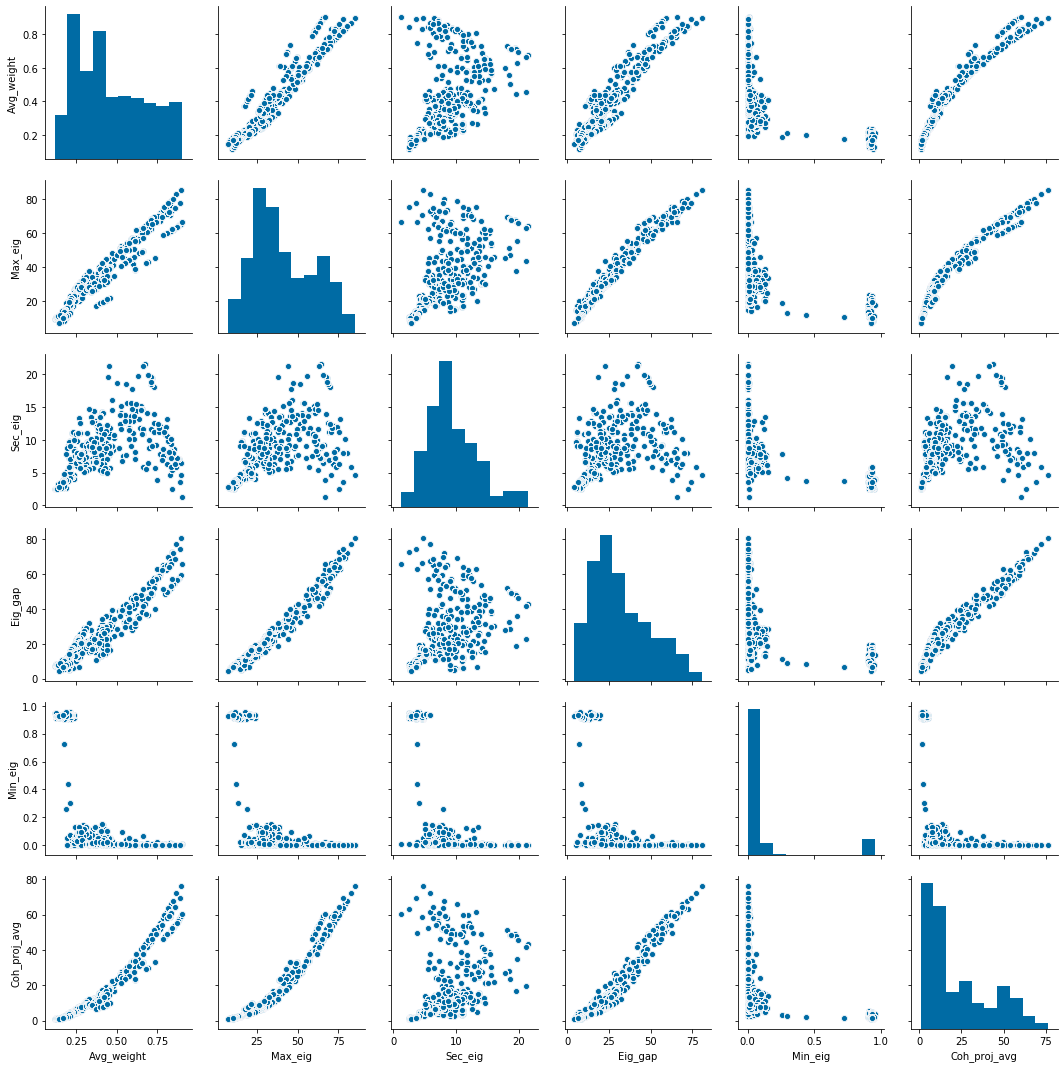

In [64]:
for band in ["theta"]: #, "beta", "gamma", "high_gamma"]:
    sns.pairplot(dataframes[band], vars=graph_feats)
    #corr.style.background_gradient(cmap='coolwarm')


In [63]:
dataframes["theta"].corr()

Initial_coh  Coh_proj      PC1a      PC2a      PC1b  \
Initial_coh             1.000000  0.828114 -0.083362 -0.065298 -0.083362   
Coh_proj                0.828114  1.000000 -0.086475 -0.082067 -0.086475   
PC1a                   -0.083362 -0.086475  1.000000  0.137279  0.263255   
PC2a                   -0.065298 -0.082067  0.137279  1.000000  0.150334   
PC1b                   -0.083362 -0.086475  0.263255  0.150334  1.000000   
PC2b                   -0.065298 -0.082067  0.150334  0.329513  0.137279   
Avg_weight              0.681124  0.907576  0.012912 -0.025855  0.012912   
Max_eig                 0.654408  0.906947  0.006429 -0.036349  0.006429   
Sec_eig                 0.232962  0.258356  0.016395  0.009367  0.016395   
Eig_gap                 0.645021  0.908734  0.003101 -0.040945  0.003101   
Min_eig                -0.328680 -0.367291 -0.032891 -0.021158 -0.032891   
Coh_proj_avg            0.663017  0.932362  0.007900 -0.043721  0.007900   
cond_diff_Y            -0.236737 -0.182712  0.138245  0.127724  0.138245   
cond_diff_percent_Y    -0.256184 -0.191826  0.089712  0.086389  0.089712   
diff_Y                 -0.221718 -0.187554  0.075716  0.086323  0.075716   
diff_percent_Y         -0.221746 -0.170113  0.059883  0.062000  0.059883   

                         PC2b  Avg_weight   Max_eig   Sec_eig   Eig_gap  \
Initial_coh         -0.065298    0.681124  0.654408  0.232962  0.645021   
Coh_proj            -0.082067    0.907576  0.906947  0.258356  0.908734   
PC1a                 0.150334    0.012912  0.006429  0.016395  0.003101   
PC2a                 0.329513   -0.025855 -0.036349  0.009367 -0.040945   
PC1b                 0.137279    0.012912  0.006429  0.016395  0.003101   
PC2b                 1.000000   -0.025855 -0.036349  0.009367 -0.040945   
Avg_weight          -0.025855    1.000000  0.960777  0.342025  0.946994   
Max_eig             -0.036349    0.960777  1.000000  0.391659  0.977472   
Sec_eig              0.009367    0.342025  0.391659  1.000000  0.188631   
Eig_gap             -0.040945    0.946994  0.977472  0.188631  1.000000   
Min_eig             -0.021158   -0.482555 -0.496059 -0.481744 -0.418943   
Coh_proj_avg        -0.043721    0.973416  0.972741  0.277098  0.974657   
cond_diff_Y          0.127724   -0.116535 -0.092113  0.143565 -0.131246   
cond_diff_percent_Y  0.086389   -0.128327 -0.117715  0.073110 -0.142409   
diff_Y               0.086323   -0.135383 -0.112763  0.065876 -0.135465   
diff_percent_Y       0.062000   -0.111382 -0.096472  0.058228 -0.116323   

                      Min_eig  Coh_proj_avg  cond_diff_Y  cond_diff_percent_Y  \
Initial_coh         -0.328680      0.663017    -0.236737            -0.256184   
Coh_proj            -0.367291      0.932362    -0.182712            -0.191826   
PC1a                -0.032891      0.007900     0.138245             0.089712   
PC2a                -0.021158     -0.043721     0.127724             0.086389   
PC1b                -0.032891      0.007900     0.138245             0.089712   
PC2b                -0.021158     -0.043721     0.127724             0.086389   
Avg_weight          -0.482555      0.973416    -0.116535            -0.128327   
Max_eig             -0.496059      0.972741    -0.092113            -0.117715   
Sec_eig             -0.481744      0.277098     0.143565             0.073110   
Eig_gap             -0.418943      0.974657    -0.131246            -0.142409   
Min_eig              1.000000     -0.393936    -0.057293            -0.070377   
Coh_proj_avg        -0.393936      1.000000    -0.122069            -0.129630   
cond_diff_Y         -0.057293     -0.122069     1.000000             0.600144   
cond_diff_percent_Y -0.070377     -0.129630     0.600144             1.000000   
diff_Y              -0.009064     -0.135086     0.700773             0.429621   
diff_percent_Y      -0.041860     -0.110746     0.473193             0.785503   

                       diff_Y  diff_percent_Y  
Initial_coh         -0.221